In [2]:
!pip install --user matplotlib

  Using cached https://files.pythonhosted.org/packages/9d/40/5ba7d4a3f80d39d409f21899972596bf62c8606f1406a825029649eaa439/matplotlib-2.2.5-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/da/d1/080d2bb13773803648281a49e3918f65b31b7beebf009887a529357fd44a/backports.functools_lru_cache-1.6.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3d/78/cb9248b2289ec31e301137cedbe4ca503a74ca87f88cdbfd2f8be52323bf/kiwisolver-1.1.0-cp27-cp27mu-manylinux1_x

In [3]:
import umap
import sklearn.datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

###   t-SNE, UMAP and LargeVis

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis


In [4]:
from sklearn.manifold import TSNE
import umap

To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [5]:
mnist = sklearn.datasets.fetch_openml('mnist_784')

Below are drawings of some samples from mnist and fmnist data sets

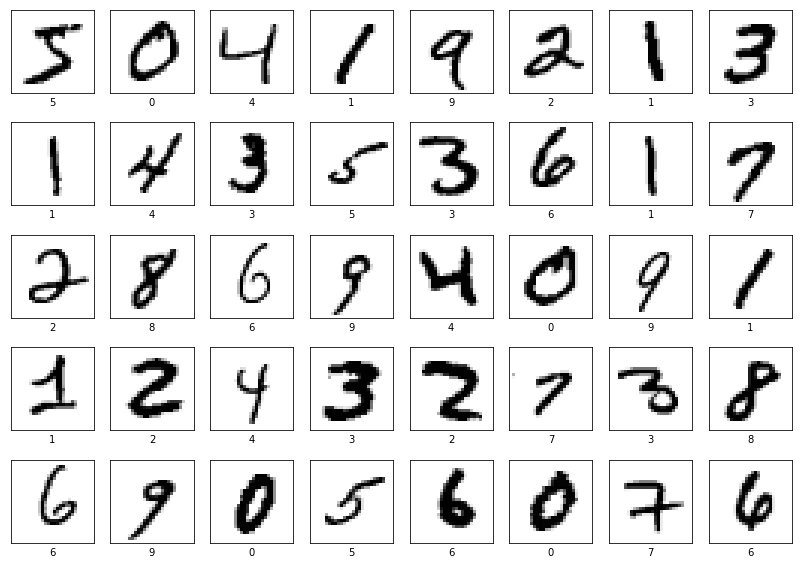

In [6]:
mnist_names = [i for i in range(10)]
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, you need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

In [ ]:
def display_transformation(points_transformed, colors, labels=[]):
  points_transformed_t = points_transformed.T

  fig = plt.figure()
  ax = fig.add_subplot()
  scatter = ax.scatter(points_transformed_t[0], points_transformed_t[1], c=colors, cmap=plt.cm.coolwarm)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.legend(handles=scatter.legend_elements()[0], labels=labels)
  plt.rcParams["figure.figsize"] = [12, 6]

#MNIST

In [7]:
LIMIT = 2000
PERPLEXITY = 30

mnist_data = mnist.data[:LIMIT]
mnist_labels = list(map(int, mnist.target[:LIMIT].tolist()))

In [8]:
def save_data_to_file(data, file_name):
    with open(file_name, 'w') as output:
        for dim in data.shape:
            output.write(str(dim)+" ")
        output.write("\n")
        for i in data:
            for j in i:
                output.write(str(j)+" ")
                
def save_labels_to_file(labels, file_name):
    with open(file_name, 'w') as output:
        for l in labels:
            output.write(str(l) + "\n")

In [17]:
def plot_LargeVis(data_file, labels_file, output_plot):
    label = []
    if labels_file != '':
        for line in open(labels_file):
            label.append(line.strip())

    N = M = 0
    all_data = {}
    for i, line in enumerate(open(data_file)):
        vec = line.strip().split(' ')
        if i == 0:
            N = int(vec[0])
            M = int(vec[1])
        elif i <= N:
            if labels_file == '':
                label.append(0)
            all_data.setdefault(label[i-1], []).append((float(vec[-2]), float(vec[-1])))

    colors = plt.cm.rainbow(np.linspace(0, 1, len(all_data)))

    for color, ll in zip(colors, sorted(all_data.keys())):
        x = [t[0] for t in all_data[ll]]
        y = [t[1] for t in all_data[ll]]
        plt.plot(x, y, '.', color = color, markersize = 1)
    plt.savefig(output_plot, dpi = 500)

In [10]:
save_data_to_file(mnist_data, "input.txt")
save_labels_to_file(mnist_labels, "input_labels.txt")

In [19]:
import LargeVis

LargeVis.loadfile("input.txt")
Y = LargeVis.run(3)
LargeVis.save("output.txt")

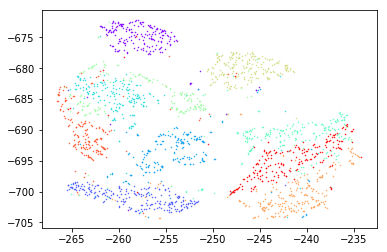

In [21]:
plot_LargeVis("output.txt", "input_labels.txt", "plot_copy.jpg")

#FMNIST

In [22]:
fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')

/home/ilona/.local/lib/python2.7/site-packages/sklearn/datasets/openml.py:61: RuntimeWarning: Invalid cache, redownloading file
  RuntimeWarning)


UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 54: ordinal not in range(128)

In [17]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

"\nfmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',\n               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']\n \nplt.figure(figsize=(14,10))\nfor i in range(40):\n    plt.subplot(5, 8, i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.grid(False)\n    plt.imshow(fmnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)\n    plt.xlabel(fmnist_names[int(fmnist.target[i])])\nplt.show()\n"

In [0]:
LIMIT = 2000
PERPLEXITY = 30

fmnist_data = fmnist.data[:LIMIT]
fmnist_labels = list(map(int, fmnist.target[:LIMIT].tolist()))

##LargeVis

In [0]:
# TODO locally

#### In order to compare the results of these three methods, calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to 2 different classes